### Just some utils

In [1]:
%%capture
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!apt-get install -y python-opengl > /dev/null 2>&1
!pip install xvfbwrapper
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install numpy gymnasium
!apt-get install xvfb

In [2]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont

def create_episode_array(episode_number, screen_shape: tuple[int,int,int]):
  """Creates an array representing the screen with a white background and episode number text."""
  screen_height, screen_width  = screen_shape[:2]
  # Create a white background image
  image = Image.new("RGB", (screen_width, screen_height), "white")
  draw = ImageDraw.Draw(image)

  # Choose a font and size (adjust as needed)
  font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 24)  # Replace with your font path and size

  # Add text showing the episode number
  text = f"Episode: {episode_number}"
  # Use textlength to get the width
  text_width = draw.textlength(text, font=font)
  # Get font height using getbbox method of the font object
  # getbbox returns (x0, y0, x1, y1) -  we need (y1 - y0) for height
  ascent, descent = font.getmetrics()
  text_height = ascent + descent  # Using getmetrics for font height

  x = (screen_width - text_width) // 2
  y = (screen_height - text_height) // 2
  draw.text((x, y), text, fill="black", font=font)

  # Convert image to a NumPy array
  array = np.array(image)

  return [array, (array*0.75).astype(np.uint8), (array*0.25).astype(np.uint8), array*0]

In [3]:
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from tqdm import tqdm
import imageio
display = Display(visible=0, size=(400, 300))
display.start()

# The real deal

In [4]:
import random
import gymnasium as gym
import numpy as np
from gymnasium.wrappers import TimeLimit

env = gym.make("Taxi-v3")

# This expresses the weight that the current value has regarding the update
# 1-alpha * previous + alpha * current
alpha = 0.9

# This is the decay factor for the reward, it describes the impact of future reward,
gamma = 0.95

# Initially we want our system to be 'curious' by exploring, effectively bypassing the approximated reward function
# this factor determines the chance of selection an action randomly
epsilon = 1

# It makes sense that as the agent learns about value function, we would give less chance to randomness
# thus we decay that chance with a factor which is:

epsilon_decay = 0.9995

# Still we do not want it to be dogmatic, and leave a chance to discovery

min_epsilon = 0.01

# This now describes how many 'lives' will the agent take have

num_episodes = 9876

# In each life, we describe how many actions the agent can do
# a low number, might not give the chance for the agent to go deep
# A high number could make get the agent explore a useless local minima
# Take the example of getting sent to buy baguettes, at the local bakery,
# Chances are, if you're not back with a few minutes, something bad happened

max_episode_steps = 98

# At each point in life we have, a defined number of actions that we can take
# This is representation by the obeservation, action table
# We initiallize it unifiormly in zeros, because we do not have any idea
# which action is good/bad given the current state (observation)

Q_table = np.zeros((env.observation_space.n, env.action_space.n))

In [5]:
# Up, Down, Right, Left, Pick a passenger, Drop him
env.action_space.n

6

In [6]:
# 25 taxi positions ( As defined by the board)
# 5 Human positions ( 4 locations ( Red, Blue, Green, Yellow) And Inside taxi)
# 4 Destination positibilities ( Red, Blue, Green, Yellow)
# 25 * 5
env.observation_space.n

500

In [7]:
# You can should be able to understand what this function does
def select_action(state,
                  Q_table,
                  epsilon = 1,
                  epsilon_decay=0.995,
                  min_epsilon = 0.01
                  ):
  # we give chance to randomness for exploration
  if random.uniform(0, 1) < epsilon:
    action = env.action_space.sample()
  else:
    # But the goal is to take the action that maximizes the reward
    action = np.argmax(Q_table[state, :])
  return action, max(min_epsilon, epsilon * epsilon_decay)

In [8]:
# before being able to select any action,
# we need to initialize our envirmement (and hence get a first state)
state = env.reset()

In [9]:
# we select a random action (given that epsilon is initially at 1)
action, _ = select_action(state, Q_table)

In [10]:
action

1

In [11]:
# let's see what are the values that returned...
env.step(action)

(24,
 -1,
 False,
 False,
 {'prob': 1.0, 'action_mask': array([1, 0, 0, 1, 0, 0], dtype=int8)})

In [12]:
# Try not to let your child get lost
env = TimeLimit(env, max_episode_steps=max_episode_steps)

In [22]:
# How many `reincarnations`
for episode in tqdm(range(1)):
  # Get the state of the new life
  state = env.reset()[0]
  # Try not to let your child get lost
  while True:
    # pick an action
    action, epsilon = select_action(state,Q_table, epsilon)
    # Move in the environement
    next_state, reward, terminated, trucated, info = env.step(action)
    # make sure to update the current state
    state = next_state
    # exit when reaching the place, or hit max_episode_steps
    if terminated or trucated:
      break

100%|██████████| 1/1 [00:00<00:00, 198.83it/s]


OK great...but where the heck is the learning part of Q-learning?

SO this is the moment to talk about the crux of Q-learning. What it essentially describe is that if some point in your adventurer's journey you find a treasure, then you should remember the path that lead you there, and you do that by distribution the reward back to that path



In [19]:
state

224

In [23]:
# here the path is described by our Q_table

# We grab the old state's reward given the action that we have taken (previous path)

prev_state_reward = Q_table[state, action]

# So we need to grab the  reward that we could get from going the next_state (our treasure)

potentation_max_next_reward = np.max(Q_table[next_state, :])

# Aaand update the old state's reward using the parameter we've defined previously

Q_table[state, action] = prev_state_reward + alpha * (reward + gamma * potentation_max_next_reward - prev_state_reward)

OK let's plug this learning back in the loop,

In [24]:
# How many `reincarnations`
for episode in tqdm(range(num_episodes)):
  # Get the state of the new life
  state = env.reset()[0]
  # Try not to let your child get lost
  while True:
    # pick an action
    action, epsilon = select_action(state, epsilon)
    # Move in the environement
    next_state, reward, terminated, trucated, info = env.step(action)
    # here the path is described by our Q_table
    # So we need t grab the max reward that we could get
    # from going the next_state
    potentation_max_next_reward = np.max(Q_table[next_state, :])
    # grab the old state's reward given the action that we have taken
    prev_state_reward = Q_table[state, action]
    # Aaand update it using the parameter we've defined previously
    Q_table[state, action] = prev_state_reward + alpha * (reward + gamma * potentation_max_next_reward - prev_state_reward)
    # make sure to update the current state
    state = next_state
    # exit when reaching the place, or hit max_episode_steps
    if terminated or trucated:
      break

100%|██████████| 9876/9876 [00:59<00:00, 165.23it/s]


Now let's what it has been learned!

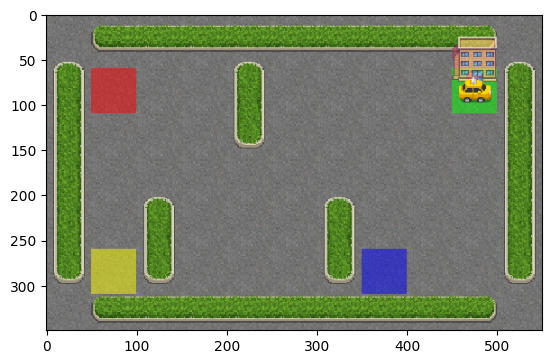

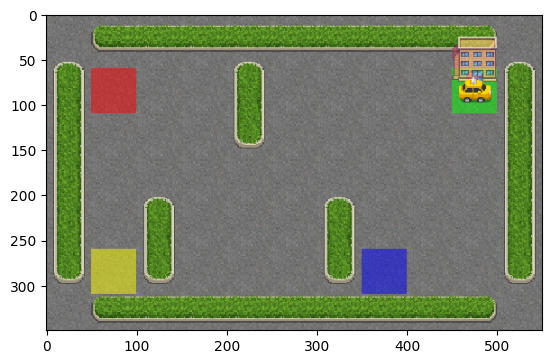

In [26]:
env = gym.make('Taxi-v3',render_mode='rgb_array')
env = TimeLimit(env, max_episode_steps=max_episode_steps)

# to make our gif animation :))
screen_list = []

for episode in range(5):
  # Get the state of the new life
  state = env.reset()[0]
  # Try not to let your child get lost
  screen = create_episode_array(episode, env.render().shape)
  screen_list.extend(screen)
  while True:
    screen = env.render()
    screen_list.append(screen)
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    # pick an action
    action = np.argmax(Q_table[state, :])
    # Move in the environement
    next_state, reward, terminated, trucated, info = env.step(action)
    # make sure to update the current state
    state = next_state
    if terminated:
      print('seems like we reached our goal')
      screen = env.render()
      screen_list.append(screen)
      plt.imshow(screen)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())
      break
    if trucated:
      # most likely dind't reach our goal
      print(f'We hit the maximum number of episodes with reward {reward}')
      screen = env.render()
      plt.imshow(screen)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())
      break

env.close()

imageio.mimsave('taxi_qlearning.gif', screen_list, fps=3)